# Phase 1 — EDA & Time-Based Train/Test Split
**Dataset:** `creditcard.csv`  
**Goal:** Exploratory data analysis + temporal split. No models, no SMOTE, no scaling.

## Step 1 — Basic Checks

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")

# ── Load ──────────────────────────────────────────────────────────────────────
DATA_PATH = "data/raw/creditcard.csv"
df = pd.read_csv(DATA_PATH)

# ── Shape ─────────────────────────────────────────────────────────────────────
print("=" * 50)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# ── Missing values ────────────────────────────────────────────────────────────
missing = df.isnull().sum()
print(f"\nMissing values: {missing.sum()} total")
if missing.sum() > 0:
    print(missing[missing > 0])

# ── Duplicates ────────────────────────────────────────────────────────────────
dupes = df.duplicated().sum()
print(f"\nDuplicate rows: {dupes:,}")

# ── Class distribution ────────────────────────────────────────────────────────
counts = df["Class"].value_counts().sort_index()
pcts   = df["Class"].value_counts(normalize=True).sort_index() * 100

print("\nClass Distribution:")
print(f"  Legitimate (0) : {counts[0]:>7,}  ({pcts[0]:.4f}%)")
print(f"  Fraud      (1) : {counts[1]:>7,}  ({pcts[1]:.4f}%)")
print("=" * 50)

Shape: 284,807 rows × 31 columns

Missing values: 0 total

Duplicate rows: 1,081

Class Distribution:
  Legitimate (0) : 284,315  (99.8273%)
  Fraud      (1) :     492  (0.1727%)


## Step 2 — Temporal Analysis

Time column already sorted: True

Time range: 0.00h  →  48.00h


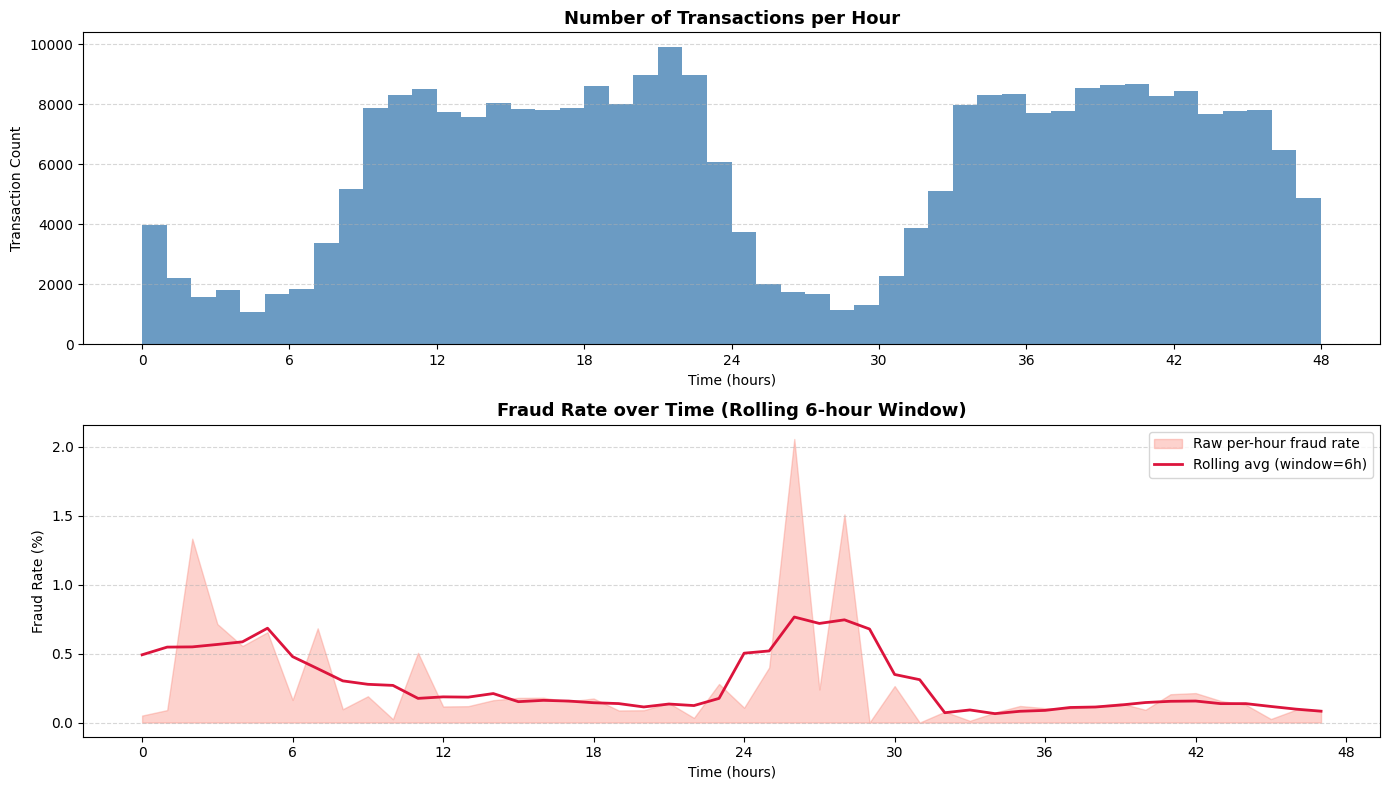

Plot saved to data/processed/temporal_analysis.png


In [6]:
# ── Sort by Time if needed ─────────────────────────────────────────────────────
is_sorted = df["Time"].is_monotonic_increasing
print(f"Time column already sorted: {is_sorted}")
if not is_sorted:
    df = df.sort_values("Time").reset_index(drop=True)
    print("  → Sorted ascending by Time.")

# ── Convert seconds → hours ───────────────────────────────────────────────────
df["Time_hours"] = df["Time"] / 3600.0
print(f"\nTime range: {df['Time_hours'].min():.2f}h  →  {df['Time_hours'].max():.2f}h")

# ── Plot 1: Number of transactions over time (hourly bins) ────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# bin edges at every integer hour
max_hour = int(df["Time_hours"].max()) + 1
bins = range(0, max_hour + 1)

all_counts, bin_edges, _ = axes[0].hist(
    df["Time_hours"], bins=bins, color="steelblue", edgecolor="none", alpha=0.8
)
axes[0].set_title("Number of Transactions per Hour", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("Transaction Count")
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(6))
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# ── Plot 2: Fraud rate over time (rolling window) ─────────────────────────────
# Bin each transaction to an integer hour bucket, then compute the fraud rate per bucket
df["Time_bin"] = df["Time_hours"].astype(int)
hourly = df.groupby("Time_bin")["Class"].mean().reset_index()
hourly.columns = ["Hour", "Fraud_Rate"]

# Smooth with a rolling window of 6 hours
window = 6
hourly["Fraud_Rate_Smooth"] = hourly["Fraud_Rate"].rolling(window, min_periods=1, center=True).mean()

axes[1].fill_between(
    hourly["Hour"], hourly["Fraud_Rate"] * 100,
    color="salmon", alpha=0.35, label="Raw per-hour fraud rate"
)
axes[1].plot(
    hourly["Hour"], hourly["Fraud_Rate_Smooth"] * 100,
    color="crimson", linewidth=2, label=f"Rolling avg (window={window}h)"
)
axes[1].set_title(f"Fraud Rate over Time (Rolling {window}-hour Window)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Time (hours)")
axes[1].set_ylabel("Fraud Rate (%)")
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(6))
axes[1].legend()
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("data/processed/temporal_analysis.png", dpi=150, bbox_inches="tight")
plt.show()
print("Plot saved to data/processed/temporal_analysis.png")

## Step 3 — Time-Based Train/Test Split
First 80% of rows (ordered by `Time`) → **Train**. Last 20% → **Test**. No `sklearn`, no shuffling.

In [7]:
# ── Ensure data is sorted by Time ─────────────────────────────────────────────
df_sorted = df.sort_values("Time").reset_index(drop=True)

# ── 80 / 20 cutoff by row index (no sklearn, no shuffle) ──────────────────────
cutoff = int(len(df_sorted) * 0.80)

train_df = df_sorted.iloc[:cutoff].copy()
test_df  = df_sorted.iloc[cutoff:].copy()

# ── Report ────────────────────────────────────────────────────────────────────
train_fraud_rate = train_df["Class"].mean() * 100
test_fraud_rate  = test_df["Class"].mean()  * 100

print("=" * 50)
print(f"Total rows  : {len(df_sorted):,}")
print(f"Cutoff index: {cutoff:,}  (80%)")
print()
print(f"Train size  : {len(train_df):,} rows")
print(f"  Time range: {train_df['Time_hours'].min():.2f}h → {train_df['Time_hours'].max():.2f}h")
print(f"  Fraud rate: {train_fraud_rate:.4f}%")
print()
print(f"Test  size  : {len(test_df):,} rows")
print(f"  Time range: {test_df['Time_hours'].min():.2f}h → {test_df['Time_hours'].max():.2f}h")
print(f"  Fraud rate: {test_fraud_rate:.4f}%")
print("=" * 50)

Total rows  : 284,807
Cutoff index: 227,845  (80%)

Train size  : 227,845 rows
  Time range: 0.00h → 40.35h
  Fraud rate: 0.1830%

Test  size  : 56,962 rows
  Time range: 40.35h → 48.00h
  Fraud rate: 0.1317%


## Step 4 — Save Clean Files
Outputs written to `data/processed/`. No shuffling, no SMOTE, no scaling, no modeling.

In [8]:
import os

PROCESSED = "data/processed"
os.makedirs(PROCESSED, exist_ok=True)

# ── Drop helper columns used only for analysis ────────────────────────────────
DROP_COLS = ["Time_hours", "Time_bin"]

train_clean = train_df.drop(columns=[c for c in DROP_COLS if c in train_df.columns])
test_clean  = test_df.drop(columns=[c for c in DROP_COLS if c in test_df.columns])

# ── Separate features and target ──────────────────────────────────────────────
TARGET = "Class"

X_train = train_clean.drop(columns=[TARGET])
y_train = train_clean[[TARGET]]

X_test  = test_clean.drop(columns=[TARGET])
y_test  = test_clean[[TARGET]]

# ── Save — no index, no shuffle ───────────────────────────────────────────────
X_train.to_csv(f"{PROCESSED}/X_train.csv", index=False)
y_train.to_csv(f"{PROCESSED}/y_train.csv", index=False)
X_test.to_csv(f"{PROCESSED}/X_test.csv",   index=False)
y_test.to_csv(f"{PROCESSED}/y_test.csv",   index=False)

print("Saved to data/processed/")
for fname, obj in [("X_train.csv", X_train), ("y_train.csv", y_train),
                   ("X_test.csv",  X_test),  ("y_test.csv",  y_test)]:
    print(f"  {fname:15s}  →  {obj.shape[0]:,} rows × {obj.shape[1]} col(s)")


Saved to data/processed/
  X_train.csv      →  227,845 rows × 30 col(s)
  y_train.csv      →  227,845 rows × 1 col(s)
  X_test.csv       →  56,962 rows × 30 col(s)
  y_test.csv       →  56,962 rows × 1 col(s)
